In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/preprocessed_CTU-IoT-Malware-Capture-21-1.csv")

In [3]:
df

,id.resp_h,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,8,2,1,-0.031471,-0.120580,-0.091638,2,-0.028072,1,-0.031437,-0.033291,-0.032746,-0.035204,0
1,8,2,1,-0.031469,0.083804,0.114779,5,-0.028072,2,-0.025729,-0.022584,-0.021844,-0.016371,0
2,8,2,1,-0.025755,0.056852,-0.089369,2,-0.028072,1,-0.025729,-0.024210,-0.032746,-0.035204,0
3,8,2,1,-0.031469,0.083804,0.114779,5,-0.028072,2,-0.025729,-0.022584,-0.021844,-0.016371,0
4,8,2,1,-0.025717,0.144445,0.232731,5,-0.028072,2,-0.020022,-0.015129,-0.021844,-0.009663,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3281,16,2,0,-0.031471,-0.120580,-0.091638,2,-0.028072,1,-0.031437,-0.032071,-0.032746,-0.035204,0
3282,45,2,0,-0.031471,-0.120580,-0.091638,2,-0.028072,1,-0.031437,-0.032071,-0.032746,-0.035204,0
3283,29,2,0,-0.031469,-0.010527,0.019510,5,-0.028072,2,-0.031437,-0.032071,-0.027295,-0.025401,0
3284,38,2,0,-0.031471,-0.120580,-0.091638,2,-0.028072,1,-0.031437,-0.032071,-0.032746,-0.035204,0


# Train Test Split

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## Isolation Forest

![Alt Text](https://miro.medium.com/v2/resize:fit:725/1*y3wXEId0poYUIzCD3HBh4w.png)

This particular model works by isolating observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. Random partitioning produces noticeably shorter paths for anomalies. Therefore, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [5]:
# Use SciKit Learn's IsolationForest implementation
from sklearn.ensemble import IsolationForest

# train the model
isolation_forest = IsolationForest(n_estimators=100, contamination=0.055, random_state=42)
isolation_forest.fit(X_train)

# add the anomaly score to the dataframe
df['anomaly_score'] = isolation_forest.decision_function(X)

# map the anomaly score to 0 and 1
df["prediction"] = df["anomaly_score"].map(lambda x: 1 if x < -0.2 else 0)

In [6]:
print(df['prediction'].value_counts())
print(df["label"].value_counts())

prediction
0    3275
1      11
Name: count, dtype: int64
label
0    3272
1      14
Name: count, dtype: int64


In [7]:
# all rows which were right
true_positives = df[(df["label"] == 1) & (df["prediction"] == 1)]

false_negatives = df[(df["label"] == 1) & (df["prediction"] == 0)]

false_positives = df[(df["label"] == 0) & (df["prediction"] == 1)]


In [8]:
true_positives.head()

,id.resp_h,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,anomaly_score,prediction
2034,28,1,0,38.691246,36.801047,37.197164,5,22.037580,4,38.731945,38.705256,38.825359,38.894854,1,-0.243830,1
3146,28,1,0,33.671470,32.973901,33.331958,4,48.084333,5,33.606869,33.595153,33.472762,33.221891,1,-0.245072,1
3285,28,1,0,25.534868,27.244412,27.545491,3,22.037580,6,25.559701,25.605187,25.596488,25.813682,1,-0.226494,1


In [9]:
false_negatives

,id.resp_h,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,anomaly_score,prediction
20,28,1,0,-0.027909,-0.118334,-0.089369,2,-0.028072,3,-0.020022,-0.017976,-0.032746,-0.035204,1,-0.064221,0
22,28,1,0,-0.031471,-0.120580,-0.091638,2,-0.028072,3,-0.031437,-0.034240,-0.032746,-0.035204,1,0.010459,0
25,28,1,0,-0.031471,-0.120580,-0.091638,2,-0.028072,3,-0.031437,-0.034240,-0.032746,-0.035204,1,0.010459,0
2035,28,1,0,-0.030111,-0.118334,-0.089369,1,-0.028072,7,-0.025729,-0.026108,-0.027295,-0.030045,1,-0.057065,0
2046,28,1,0,-0.027908,-0.118334,-0.089369,2,-0.028072,3,-0.020022,-0.017976,-0.032746,-0.035204,1,-0.064221,0
2048,28,1,0,-0.031471,-0.120580,-0.091638,2,-0.028072,3,-0.031437,-0.034240,-0.032746,-0.035204,1,0.010459,0
2049,28,1,0,-0.031471,-0.120580,-0.091638,2,-0.028072,3,-0.031437,-0.034240,-0.032746,-0.035204,1,0.010459,0
2050,28,1,0,-0.027884,-0.118334,-0.089369,2,-0.028072,3,-0.020022,-0.017976,-0.032746,-0.035204,1,-0.064221,0
2052,28,1,0,-0.031471,-0.120580,-0.091638,2,-0.028072,3,-0.031437,-0.034240,-0.032746,-0.035204,1,0.010459,0
2053,28,1,0,-0.031471,-0.120580,-0.091638,2,-0.028072,3,-0.031437,-0.034240,-0.032746,-0.035204,1,0.010459,0


In [10]:
false_positives

,id.resp_h,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,anomaly_score,prediction
74,16,2,0,0.027942,0.959735,0.999421,5,-0.028072,2,0.019928,0.060635,0.021761,0.062832,0,-0.201678,1
178,38,2,0,0.049652,0.744121,0.781663,5,-0.028072,2,0.008514,0.040034,0.010860,0.043225,0,-0.201048,1
228,29,2,0,0.053123,0.744121,0.781663,5,-0.028072,2,0.008514,0.040034,0.010860,0.043225,0,-0.200500,1
313,19,2,0,0.048474,0.744121,0.781663,5,-0.028072,2,0.008514,0.040034,0.010860,0.043225,0,-0.201048,1
357,45,2,0,0.051922,0.744121,0.781663,5,-0.028072,2,0.008514,0.040034,0.010860,0.043225,0,-0.202695,1
1361,21,2,0,0.048624,0.744121,0.781663,5,-0.028072,2,0.008514,0.040034,0.010860,0.043225,0,-0.200500,1
1949,46,2,0,0.045032,0.744121,0.781663,5,-0.028072,2,0.008514,0.040034,0.010860,0.043225,0,-0.201048,1
2673,38,2,0,0.049616,0.744121,0.781663,5,-0.028072,2,0.008514,0.040034,0.010860,0.043225,0,-0.201048,1


[]

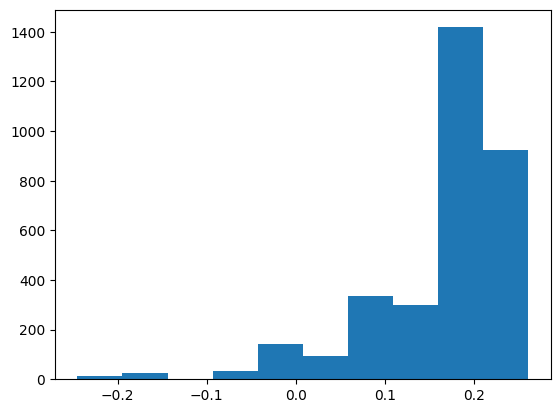

In [11]:
plt.hist(df["anomaly_score"], bins=10)
plt.plot()

# Error analysis
Taking a look at the features of the malicious examples which the model misclassified, we can see that orig_bytes is virtually zero on all of the misclassifed, and the correctly classified malicious examples were closer to 1 in orig_bytes.

Also, conn_state is 2 for most of the misclassified examples, and 5,4,3 for the correctly classified. It is 5 for most of the FN examples.

Missed bytes are not 0 in the TP, but are 0 in the FN.

orig_pkts is virtually 0 in the FN, but not in the TP, as well as orig_ip_bytes, resp_pkts and resp_ip_bytes.

In [12]:
df[df["resp_pkts"] > 0.001]

,id.resp_h,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,anomaly_score,prediction
74,16,2,0,0.027942,0.959735,0.999421,5,-0.028072,2,0.019928,0.060635,0.021761,0.062832,0,-0.201678,1
178,38,2,0,0.049652,0.744121,0.781663,5,-0.028072,2,0.008514,0.040034,0.010860,0.043225,0,-0.201048,1
198,37,2,0,0.047329,0.744121,0.781663,5,-0.028072,2,0.008514,0.040034,0.010860,0.043225,0,-0.199952,0
228,29,2,0,0.053123,0.744121,0.781663,5,-0.028072,2,0.008514,0.040034,0.010860,0.043225,0,-0.200500,1
313,19,2,0,0.048474,0.744121,0.781663,5,-0.028072,2,0.008514,0.040034,0.010860,0.043225,0,-0.201048,1
357,45,2,0,0.051922,0.744121,0.781663,5,-0.028072,2,0.008514,0.040034,0.010860,0.043225,0,-0.202695,1
1361,21,2,0,0.048624,0.744121,0.781663,5,-0.028072,2,0.008514,0.040034,0.010860,0.043225,0,-0.200500,1
1949,46,2,0,0.045032,0.744121,0.781663,5,-0.028072,2,0.008514,0.040034,0.010860,0.043225,0,-0.201048,1
1970,13,2,0,0.045041,0.744121,0.781663,5,-0.028072,2,0.008514,0.040034,0.010860,0.043225,0,-0.198938,0
2034,28,1,0,38.691246,36.801047,37.197164,5,22.037580,4,38.731945,38.705256,38.825359,38.894854,1,-0.243830,1


[]

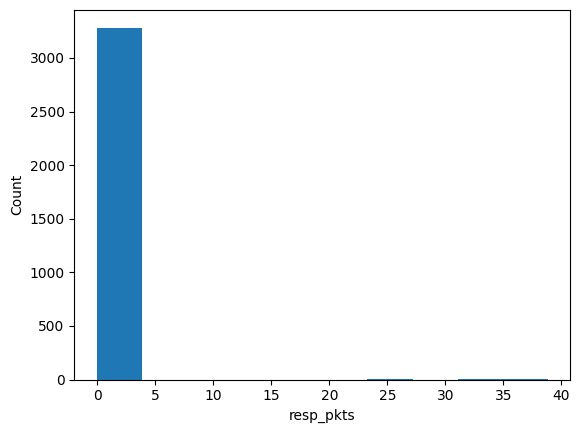

In [13]:
# plot the resp_pkts distribution
plt.hist(df["resp_pkts"], bins=10)
plt.xlabel("resp_pkts")
plt.ylabel("Count")
plt.plot()

# Conclusion
The model was able to predict only the obvious cases, the ones which were obviously an anomaly. Take the #2034, a similar case to the other 2 that the model predicted correctly. This is obviously an anomaly, and the model predicted it well, but it is not a good model if it only predicts the obvious cases. The values in this example are WAY off from the median in various columns.


In [14]:
# The obvious outliers
df[df["resp_pkts"] > 20]

,id.resp_h,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,anomaly_score,prediction
2034,28,1,0,38.691246,36.801047,37.197164,5,22.037580,4,38.731945,38.705256,38.825359,38.894854,1,-0.243830,1
3146,28,1,0,33.671470,32.973901,33.331958,4,48.084333,5,33.606869,33.595153,33.472762,33.221891,1,-0.245072,1
3285,28,1,0,25.534868,27.244412,27.545491,3,22.037580,6,25.559701,25.605187,25.596488,25.813682,1,-0.226494,1


# Big dataset

In [27]:
df_big = pd.read_csv("/home/pedranji/Projects/iot/data/preprocessed_CTU-IoT-Malware-Capture-48-1.csv")

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.2, random_state=42)

In [43]:
# how many malicious cases are there in the test set?
y_test.value_counts()

label
0    655
1      3
Name: count, dtype: int64

In [28]:
from sklearn.ensemble import IsolationForest

# train the model
isolation_forest = IsolationForest(n_estimators=100, contamination=0.055, random_state=42)
isolation_forest.fit(X_train)



IsolationForest(contamination=0.055, random_state=42)

In [39]:
anomaly_score = isolation_forest.decision_function(X_test)

# map the anomaly_score (numpy array) to 0 and 1
mapper = np.vectorize(lambda x: 1 if x < -0.2 else 0)
prediction = mapper(anomaly_score)


df_test = pd.DataFrame(X_test)
df_test["label"] = y_test
df_test['anomaly_score'] = anomaly_score
df_test['prediction'] = prediction

<Axes: >

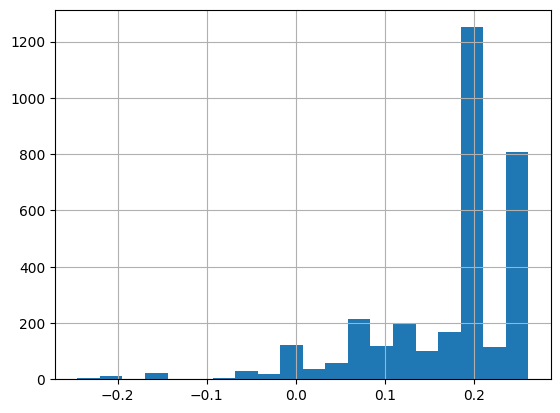

In [40]:
df["anomaly_score"].hist(bins=20)

In [42]:
# True positives, false negatives, false positives
tp = df_test[(df_test["label"] == 1) & (df_test["prediction"] == 1)]
fn = df_test[(df_test["label"] == 1) & (df_test["prediction"] == 0)]
fp = df_test[(df_test["label"] == 0) & (df_test["prediction"] == 1)]

print("True positives: ", len(tp))
print("False negatives: ", len(fn))
print("False positives: ", len(fp))

# get f1 score
from sklearn.metrics import f1_score
print("F1 score: ", f1_score(df_test["label"], df_test["prediction"]))


True positives:  0
False negatives:  3
False positives:  1
F1 score:  0.0
